### Retreiving the dataframe with some basic restructuring

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json 
from collections import Counter
import re
import ast


movie_data_unmerged = pd.read_table("movie.metadata.tsv", header=None)

movie_data_unmerged.columns = [
    "Wikipedia_movie_ID",
    "Freebase_movie_ID",
    "Movie_name",
    "Movie_release_date",
    "Movie_box_office_revenue",
    "Movie_runtime",
    "Movie_languages", 
    "Movie_countries",  
    "Movie_genres"     
]

with open("plot_summaries.txt", "r", encoding="utf-8") as f:
    file = f.readlines()

data = [line.strip().split("\t", 1) for line in file]

summaries_df = pd.DataFrame(data, columns=["Wikipedia_movie_ID", "Movie_Summary"])

summaries_df['Wikipedia_movie_ID'] = summaries_df['Wikipedia_movie_ID'].apply(int)

df_character = pd.read_table("character.metadata.tsv", header=None)

df_character.columns = ["Wikipedia_movie_ID",
"Freebase_movie_ID",
"Movie_release_date",
"Character_name",
"Actor_date_of_birth",
"Actor_gender",
"Actor_height", #in meters
"Actor_ethnicity",
"Actor_name",
"Actor_age_at_movie_release",
"Freebase_character/actor_map_ID",
"Freebase_character_ID",
"Freebase_actor_ID"]

df_character["Wikipedia_movie_ID"] = df_character["Wikipedia_movie_ID"].apply(int)
#here we only keep the year (and not the month) + we put the same format
df_character["Movie_release_date"] = df_character["Movie_release_date"].apply(lambda x: int(str(x).split("-")[0]) if type(x) == str else np.nan)

df_movie = movie_data_unmerged.merge(summaries_df, on="Wikipedia_movie_ID", how='inner')

df_movie["Movie_genres"] = df_movie["Movie_genres"].apply(lambda x: list(json.loads(x).values()))
#some movies have release date in the form year-month-day, we only want the year, and some have nan values
df_movie["Movie_release_date"] = df_movie["Movie_release_date"].apply(lambda x: int(str(x).split("-")[0]) if type(x) == str else np.nan)
df_movie.loc[df_movie["Movie_name"] == "Hunting Season", "Movie_release_date"] = 2010

def find_movie_ID(movie_name):
    return int(df_movie[df_movie["Movie_name"] == movie_name]["Wikipedia_movie_ID"].values[0])

df_imdb = pd.read_csv('merged_imdb_2.csv')
df_imdb.head()
df_imdb["actors"] = df_imdb["actors"].apply(lambda x: ast.literal_eval(x))

df_imdb.rename(columns={"Wikipedia movie ID": "Wikipedia_movie_ID"}, inplace=True)

df_actor = pd.DataFrame()
df_actor["actor"] = [item for sublist in df_imdb['actors'].tolist() for item in sublist]
df_actor = df_actor.drop_duplicates()

In [28]:
df_movie = df_movie.merge(df_imdb[["gender", "Wikipedia_movie_ID"]], on="Wikipedia_movie_ID", how='inner')

In [29]:
df_movie["Movie_countries"] = df_movie["Movie_countries"].apply(lambda x: list(json.loads(x).values()))

### Basic preliminary gender analyis

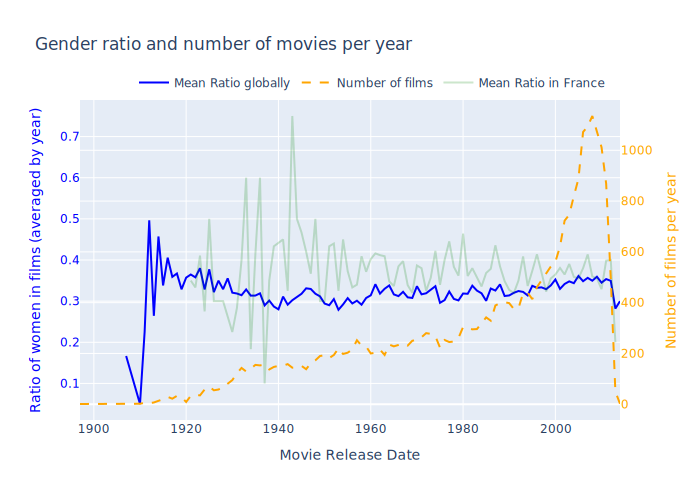

In [30]:
# here we analyse the ratio of actors/actresses by movie

df_movie["W"] = df_movie["gender"].apply(lambda x: Counter(x)["F"])
df_movie["M"] = df_movie["gender"].apply(lambda x: Counter(x)["M"])
df_movie["Ratio"] = df_movie.apply(lambda x: x["W"]/(x["W"] + x["M"]) if x["W"] + x["M"] != 0 else np.nan, axis=1)


import plotly.graph_objects as go

mean_ratio = df_movie.groupby("Movie_release_date")["Ratio"].mean()
count = df_movie.groupby("Movie_release_date").size()

mean_ratio_france = df_movie[df_movie["Movie_countries"].apply(lambda x: "France" in x)].groupby("Movie_release_date")["Ratio"].mean()

fig = go.Figure()


fig.add_trace(
    go.Scatter(
        x=mean_ratio.index,
        y=mean_ratio,
        name="Mean Ratio globally",
        mode="lines",
        line=dict(color="blue"),
    )
)


fig.add_trace(
    go.Scatter(
        x=count.index,
        y=count,
        name="Number of films",
        mode="lines",
        line=dict(color="orange", dash="dash"),
        yaxis="y2",  
    )
)

fig.add_trace(
    go.Scatter(
        x=mean_ratio_france.index,
        y=mean_ratio_france,
        name="Mean Ratio in France",
        mode="lines",
        opacity=0.2,
        line=dict(color="green"),
    )
)


fig.update_layout(
    title="Gender ratio and number of movies per year",
    xaxis=dict(title="Movie Release Date"),
    yaxis=dict(title="Ratio of women in films (averaged by year)", titlefont=dict(color="blue"), tickfont=dict(color="blue")),
    yaxis2=dict(
        title="Number of films per year",
        titlefont=dict(color="orange"),
        tickfont=dict(color="orange"),
        overlaying="y",
        side="right",
    ),
    legend=dict(x=0.1, y=1.1, orientation="h"),
)


fig.show("svg")

#to html file
#fig.write_html("Mean_Ratio_and_Count_by_Movie_Release_Date.html")

In [5]:
#finding all movie genres

all_genres = [genre for sublist in df_movie['Movie_genres'] for genre in sublist]
all_genres = list(set(all_genres))
genre_dict = {}
for genre in all_genres:
    a = float(df_movie[df_movie['Movie_genres'].apply(lambda x: genre in x)]['Ratio'].mean())
    if not np.isnan(a):
        genre_dict[genre] = [a, df_movie[df_movie['Movie_genres'].apply(lambda x: genre in x)].shape[0]]
    

In [6]:
genres_ratio = dict(sorted(genre_dict.items(), key=lambda item: item[1][0], reverse=True))

In [7]:
#keeping only the genres with more than 13 films
genres_ratio = {k: [v[0],v[1]] for k, v in genres_ratio.items() if v[1] > 13}

In [8]:
values = [v[0] for v in genres_ratio.values()]
movies_count = [v[1] for v in genres_ratio.values()]

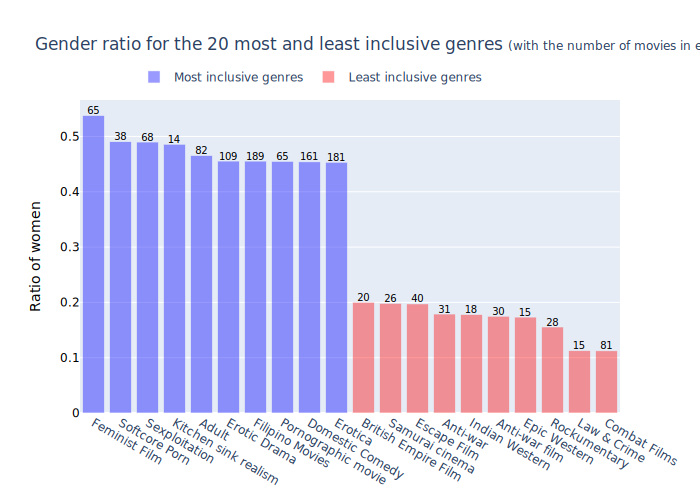

In [9]:
#analysing the inclusivness of each genre

fig = go.Figure()
fig.add_trace(
    go.Bar(
        x=list(genres_ratio.keys())[:10],
        y=values[:10],
        marker_color="blue",
        opacity=0.4,
        name="Most inclusive genres",
    )
)

fig.add_trace(
    go.Bar(
        x=list(genres_ratio.keys())[len(values)-10:],
        y=values[len(values)-10:],
        marker_color="red",
        opacity=0.4,
        name="Least inclusive genres",
    )
)

fig.update_layout(
    title="Gender ratio for the 20 most and least inclusive genres <span style='font-size: 12px;'>(with the number of movies in each genre)</span>",
    yaxis=dict(title="Ratio of women", titlefont=dict(color="black"), tickfont=dict(color="black")),
    legend=dict(x=0.1, y=1.12, orientation="h"),
)


for i, genre in enumerate(list(genres_ratio.keys())[:10]):
    fig.add_annotation(
        x=genre,
        y=values[i]+0.01,
        text=str(movies_count[i]),
        showarrow=False,
        font=dict(color="black", size=10)
    )
for i, genre in enumerate(list(genres_ratio.keys())[len(values)-10:]):
    fig.add_annotation(
        x=genre,
        y=values[len(values)-10:][i]+0.01,
        text=str(movies_count[len(values)-10:][i]),
        showarrow=False,
        font=dict(color="black", size=10)
    )
fig.show("svg")
#fig.write_html("top_genres.html")

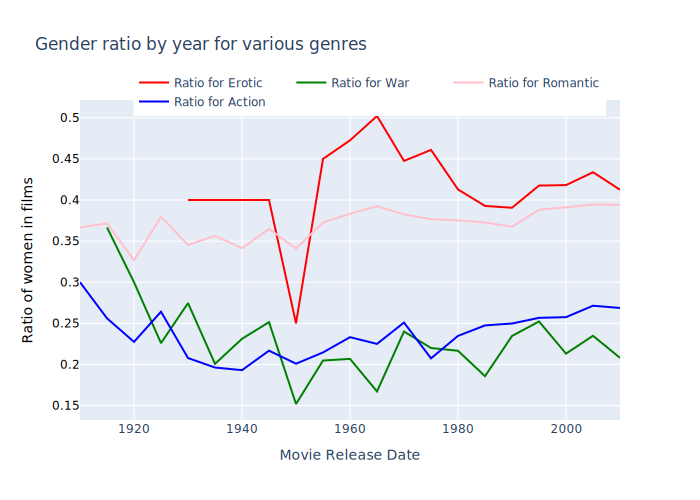

In [10]:
# NOT SHOWN ON WEBSITE

#This section was made to analyse the genre evolution. 



import plotly.graph_objects as go

genres = ["Drama", "Erotic", "Thriller"]

erotic_genres = ['Sex comedy','Erotica','Erotic thriller','Pornographic movie','Adult','Erotic Drama','Sexploitation','Softcore Porn','Gay pornography','Hardcore pornography','Pornography']
war_genres = ["War film"]
romantic_genres = ["Romantic drama", "Romantic comedy", "Romance Film"]
action_genres = ["Action", "Action/Adventure", "Adventure"]
dc = 5 #average over dc years
mean_romantic_ratio = df_movie[df_movie["Movie_genres"].apply(lambda x: any(movie_genre in x for movie_genre in romantic_genres))].groupby(df_movie["Movie_release_date"] // dc * dc)["Ratio"].mean()
mean_erotic_ratio = df_movie[df_movie["Movie_genres"].apply(lambda x: any(movie_genre in x for movie_genre in erotic_genres))].groupby(df_movie["Movie_release_date"] // dc * dc)["Ratio"].mean()
mean_war_ratio = df_movie[df_movie["Movie_genres"].apply(lambda x: any(movie_genre in x for movie_genre in war_genres))].groupby(df_movie["Movie_release_date"] // dc * dc)["Ratio"].mean()
mean_action_ratio = df_movie[df_movie["Movie_genres"].apply(lambda x: any(movie_genre in x for movie_genre in action_genres))].groupby(df_movie["Movie_release_date"] // dc * dc)["Ratio"].mean()



genre_type = [mean_erotic_ratio, mean_war_ratio, mean_romantic_ratio, mean_action_ratio]
genre_name = ["Erotic", "War", "Romantic", "Action"]

colors = ["red", "green", "pink", "blue"]

fig = go.Figure()

for genre in genre_type:
    fig.add_trace(
        go.Scatter(
            x=genre.index,
            y=genre,
            name=f"Ratio for {genre_name.pop(0)}",
            mode="lines",
            line=dict(color=colors.pop(0)),
        )
    )



fig.update_layout(
    title="Gender ratio by year for various genres",
    xaxis=dict(title="Movie Release Date"),
    yaxis=dict(title="Ratio of women in films", titlefont=dict(color="black"), tickfont=dict(color="black")),
    yaxis2=dict(
        title="Number of films per year for various genres",
        titlefont=dict(color="orange"),
        tickfont=dict(color="orange"),
        overlaying="y",
        side="right",
    ),
    legend=dict(x=0.1, y=1.1, orientation="h"),
)


fig.show("svg")

#to html file
#fig.write_html(data_folder + "ratio_evolution_by_genre.html")

## Looking at actors individually

In [11]:
df_chara_small = df_character.copy()
df_chara_small = df_chara_small.drop(["Freebase_movie_ID", "Character_name", "Actor_height", "Freebase_character_ID",
                                      "Freebase_character/actor_map_ID", "Freebase_actor_ID", "Actor_ethnicity"], axis=1)

In [12]:
df_chara_small = df_chara_small.groupby("Actor_name").agg(lambda x: x.tolist()).reset_index()

In [14]:
df_chara_small["Actor_gender"] = df_chara_small["Actor_gender"].apply(np.unique).apply(lambda x: x[0])
df_chara_small["Actor_date_of_birth"] = df_chara_small["Actor_date_of_birth"].apply(np.unique).apply(lambda x: x[0])
df_chara_small = df_chara_small[df_chara_small["Actor_gender"].isin(["M", "F"])]
df_chara_small.head(5)

,Actor_name,Wikipedia_movie_ID,Movie_release_date,Actor_date_of_birth,Actor_gender,Actor_age_at_movie_release
0,Cesarine Prinz\t,"[22643470, 22643388]","[1926.0, 1922.0]",1883-12-20,F,"[nan, nan]"
1,Daniel Newman,[20116200],[1998.0],1976-05-12,M,[22.0]
2,'Big Bill' Giddinger,[15056534],[1911.0],NaN,M,[nan]
3,'Big' Lee,[23010798],[1973.0],NaN,M,[nan]
5,'Crazy George' Henderson,[10050502],[1975.0],NaN,M,[nan]


In [15]:
#some date of birth were not correct
#these actors specifically because they made a lot of movies. It will be useful later 
df_chara_small.loc[df_chara_small["Actor_name"] == "Harrison Ford", "Actor_date_of_birth"] = 1942
df_chara_small.loc[df_chara_small["Actor_name"] == "Edward Burns", "Actor_date_of_birth"] = 1968 
df_chara_small.loc[df_chara_small["Actor_name"] == "Don Wilson", "Actor_date_of_birth"] = 1954

In [16]:
#the starting career is defined as the year of firt movie release
df_chara_small["Starting_career"] = df_chara_small["Movie_release_date"].apply(min)

In [18]:
#here we fetch the first roles from imdb to merge to the df_chara_small

first_role_df = df_imdb[["first_role_actor", "Movie_release_date_x"]].groupby("first_role_actor").agg(lambda x: x.tolist()).reset_index()
first_role_df = first_role_df.rename(columns={"first_role_actor": "Actor_name", "Movie_release_date_x": "Movie_release_date_1st_role"})
first_role_df.head(5)

,Actor_name,Movie_release_date_1st_role
0,'University' Jeevan,"[2007, 2006, 2008]"
1,'Weird Al' Yankovic,[1989]
2,2Mex,[2008]
3,50 Cent,"[2011, 2012, 2011, 2005]"
4,A. Michael Baldwin,"[2008, 1998, 1979]"


In [19]:
df_chara_small = df_chara_small.merge(first_role_df, on="Actor_name", how="outer")
df_chara_small.head(5)

,Actor_name,Wikipedia_movie_ID,Movie_release_date,Actor_date_of_birth,Actor_gender,Actor_age_at_movie_release,Starting_career,Movie_release_date_1st_role
0,Cesarine Prinz\t,"[22643470, 22643388]","[1926.0, 1922.0]",1883-12-20,F,"[nan, nan]",1922.0,NaN
1,Daniel Newman,[20116200],[1998.0],1976-05-12,M,[22.0],1998.0,NaN
2,'Big Bill' Giddinger,[15056534],[1911.0],NaN,M,[nan],1911.0,NaN
3,'Big' Lee,[23010798],[1973.0],NaN,M,[nan],1973.0,NaN
4,'Crazy George' Henderson,[10050502],[1975.0],NaN,M,[nan],1975.0,NaN


In [20]:
#computing how many years it took the actor to get 1st role. 
import math
def years_to_first(x, start):
    if type(x) == list:
        return min(x) - start
    else:
        return np.nan

In [21]:
df_chara_small["Years_to_1st"] = df_chara_small.apply(lambda x: years_to_first(x["Movie_release_date_1st_role"], x["Starting_career"]), axis=1)

In [22]:
#number of actors that have and do not have first role (ever)
len(df_chara_small)

101877

In [23]:
#selecting actors that have or had first role in their career 
df_chara_small = df_chara_small[(df_chara_small["Years_to_1st"].isnull()) | (df_chara_small["Years_to_1st"] > 0)]

In [24]:
#remaing actors from the dataframe
len(df_chara_small)

96416

In [25]:
def find_movie_genres(films_id):
    if type(films_id) != list:
        return np.nan
    else:
        return df_movie[df_movie["Wikipedia_movie_ID"].isin(films_id)]["Movie_genres"].apply(lambda x: list(x)).sum()


In [26]:
df_chara_small["Movie_genres"] = df_chara_small["Wikipedia_movie_ID"].apply(find_movie_genres)

In [32]:
df_chara_small.groupby("Actor_gender")["Years_to_1st"].mean()

Actor_gender
F    7.837449
M    9.169874
Name: Years_to_1st, dtype: float64

In [33]:
role_dict = df_imdb["first_role_gender"].value_counts().to_dict()
print(f'The number of woman actress as first role is {role_dict["F"]}, while the actors represent {role_dict["M"]}')
print("")
print(f"Thus the ratio actors/actress is {role_dict['M']/(role_dict['F']+role_dict['M'])}")

The number of woman actress as first role is 13647, while the actors represent 35196

Thus the ratio actors/actress is 0.7205945580738284


In [34]:
#here we add colomns to imdb dataframe for gender type in binary form 
def role_man(first_role):
    return 1 if first_role == "M" else 0
role = ["first", "second", "third"]
for el in role:
    df_imdb["Binary_"+el] = df_imdb[f"{el}_role_gender"].apply(lambda x: role_man(x))

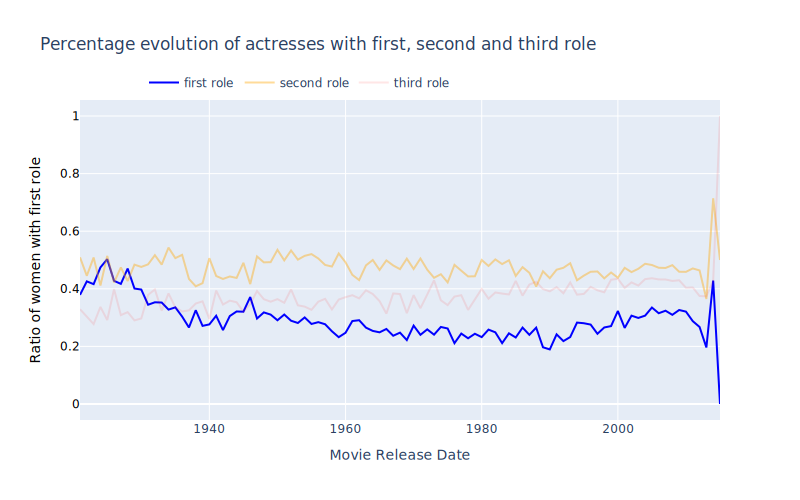

In [35]:
fig = go.Figure()

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
)
colors = ["blue", "orange", "red"]
op =[1, 0.4, 0.1]

for el in role:
    num_m = df_imdb[df_imdb["Movie_release_date_x"] >1920].groupby("Movie_release_date_x")[f"Binary_{el}"].sum()
    num_w = df_imdb[df_imdb["Movie_release_date_x"] >1920].groupby("Movie_release_date_x")[f"Binary_{el}"].count() - num_m

    fig.add_trace(
        go.Scatter(
            x=num_m.index,
            y=num_w/(num_m+num_w),
            name=f"{el} role",
            mode="lines",
            line=dict(color=colors.pop(0)),
            opacity=op.pop(0)
        )
    )


fig.update_layout(
    title="Percentage evolution of actresses with first, second and third role",
    xaxis=dict(title="Movie Release Date"),
    yaxis=dict(title="Ratio of women with first role", titlefont=dict(color="black"), tickfont=dict(color="black")),
    legend=dict(x=0.1, y=1.1, orientation="h"),
)
fig.show("svg")

#fig.write_html(data_folder + "percentage_evolution_of_actresses.html")

In [36]:
#finding the gender ratio for first role
genre_dict_first = {}
all_genres = list(set(all_genres))
for genre in all_genres:
    dictt = df_imdb[df_imdb["Movie_genres"].apply(lambda x: genre in x)]["Binary_first"].value_counts().to_dict()
    if len(dictt) == 2:
        m = dictt[1]
        w = dictt[0]
    genre_dict_first[genre] = [m, w, w/(m+w)]


In [37]:
genre_dict_first = dict(sorted(genre_dict_first.items(), key=lambda item: item[1][2], reverse=True))
genre_dict_first = {k: v for k, v in genre_dict_first.items() if v[0] + v[1] > 20}

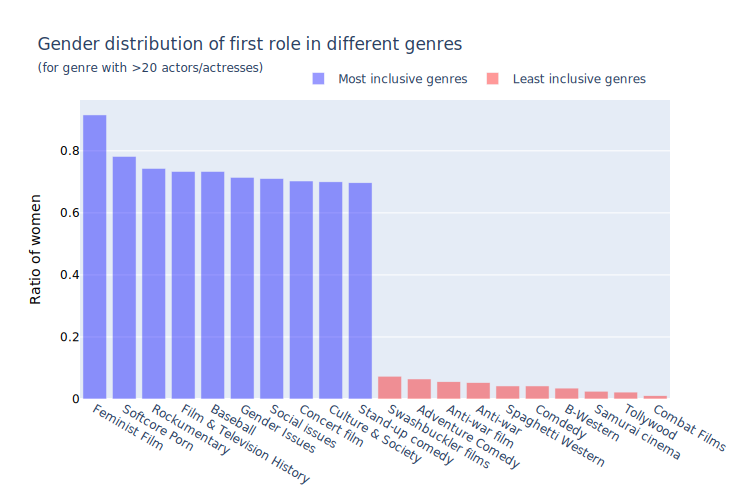

In [38]:
values = [v[2] for v in genre_dict_first.values()]
fig = go.Figure()
fig.update_layout(
    autosize=False,
    width=750,
    height=500,
)
fig.add_trace(
    go.Bar(
        x=list(genre_dict_first.keys())[:10],
        y=values[:10],
        marker_color="blue",
        opacity=0.4,
        name="Most inclusive genres",
    )
)

fig.add_trace(
    go.Bar(
        x=list(genre_dict_first.keys())[len(values)-10:],
        y=values[len(values)-10:],
        marker_color="red",
        opacity=0.4,
        name="Least inclusive genres",
    )
)

fig.update_layout(
    title="Gender distribution of first role in different genres <br><span style='font-size: 12px;'>(for genre with >20 actors/actresses)</span>",
    yaxis=dict(title="Ratio of women", titlefont=dict(color="black"), tickfont=dict(color="black")),
    legend=dict(x=0.37, y=1.12, orientation="h", bgcolor="rgba(0,0,0,0)"),
)

fig.show("svg")
fig.write_html("first_role_genre.html")

In [39]:
erotic_genres = ['Sex comedy','Erotica','Erotic thriller','Pornographic movie','Adult','Erotic Drama','Sexploitation','Softcore Porn','Gay pornography','Hardcore pornography','Pornography']
war_genres = ["War film"]
religious_genres = ["Religious Film"]
romantic_genres = ["Romantic drama", "Romantic comedy, Romance Film"]

In [40]:
#here is an analysis of the number of years to 1st role by movie genre
print('erotic')
print(df_chara_small[df_chara_small["Movie_genres"].apply(lambda x: any(i in x for i in erotic_genres) if type(x) == list else False)].groupby("Actor_gender")["Years_to_1st"].mean())
print('')
print('war')
print(df_chara_small[df_chara_small["Movie_genres"].apply(lambda x: any(i in x for i in war_genres) if type(x) == list else False)].groupby("Actor_gender")["Years_to_1st"].mean())
print('')
print('religious')
print(df_chara_small[df_chara_small["Movie_genres"].apply(lambda x: any(i in x for i in religious_genres) if type(x) == list else False)].groupby("Actor_gender")["Years_to_1st"].mean())
print('')
print('romantic')
print(df_chara_small[df_chara_small["Movie_genres"].apply(lambda x: any(i in x for i in romantic_genres) if type(x) == list else False)].groupby("Actor_gender")["Years_to_1st"].mean())
print('')

erotic
Actor_gender
F    8.138528
M    9.299870
Name: Years_to_1st, dtype: float64

war
Actor_gender
F    8.434866
M    9.509904
Name: Years_to_1st, dtype: float64

religious
Actor_gender
F    8.750000
M    9.459459
Name: Years_to_1st, dtype: float64

romantic
Actor_gender
F    8.473399
M    9.291090
Name: Years_to_1st, dtype: float64



In [41]:
all_genres = [genre for sublist in df_movie['Movie_genres'] for genre in sublist]
genre_counts = Counter(all_genres)

In [42]:
#analysing the ratio of number of years to 1st role between gender for all the genre 
def ratio_years_to_first(movie_genre):
    manwoman = df_chara_small[df_chara_small["Movie_genres"].apply(lambda x: movie_genre in x if type(x) == list else False)].groupby("Actor_gender")["Years_to_1st"].mean()
    if len(manwoman) != 2 or math.isnan(manwoman["M"]):
        return np.nan
    else:
        return manwoman["M"]/manwoman["F"]
    
genres = list(set([item for sublist in df_movie["Movie_genres"].tolist() for item in sublist]))

dict_genres = {}
for genre in genres:
    dict_genres[genre] = [ratio_years_to_first(genre), genre_counts[genre]/(sum(genre_counts.values()))]

In [43]:
dict(sorted(dict_genres.items(), key=lambda item: item[1][1], reverse=True))

weighted_ratio = {}
for key in dict_genres.keys():
    weighted_ratio[key] = dict_genres[key][0] * dict_genres[key][1]
np.nansum(list(weighted_ratio.values()))

1.1458116609553501

In [44]:
#shows on average the number of films with first role per gender
df_chara_small["Number_movies_1st"] = df_chara_small["Movie_release_date_1st_role"].apply(lambda x: len(x) if type(x) == list else np.nan)
df_chara_small.groupby("Actor_gender")["Number_movies_1st"].mean()

Actor_gender
F    2.673256
M    3.439831
Name: Number_movies_1st, dtype: float64

In [45]:
#checking with famous actresses. She has 9 films as first role
df_chara_small[df_chara_small["Actor_name"] == "Scarlett Johansson"]

,Actor_name,Wikipedia_movie_ID,Movie_release_date,Actor_date_of_birth,Actor_gender,Actor_age_at_movie_release,Starting_career,Movie_release_date_1st_role,Years_to_1st,Movie_genres,Number_movies_1st
85720,Scarlett Johansson,"[22144721, 22144721, 11723307, 1599839, 595971...","[2010.0, 2010.0, 1999.0, 2004.0, 2003.0, 2001....",1984-11-22,F,"[25.0, 25.0, 14.0, 20.0, 18.0, 16.0, 11.0, 21....",1994.0,"[1999, 2007, 2003, 1996, 2005, 2004, 2006, 200...",2.0,"[Costume drama, History, Period piece, Drama, ...",9.0


In [46]:
#doing some analysis between the most famous actors/actresses. To see how they compare. 
famous_actress = ["Scarlett Johansson", "Jennifer Lawrence", "Angelina Jolie", "Meryl Streep", "Julia Roberts", "Cate Blanchett", "Nicole Kidman", "Charlize Theron", "Natalie Portman", "Emma Stone", "Anne Hathaway", "Sandra Bullock"] #"Reese Witherspoon", "Jessica Chastain", "Keira Knightley", "Kate Winslet", "Amy Adams", "Halle Berry", "Diane Keaton", "Julianne Moore", "Maggie Smith"]
print(len(famous_actress))
famous_actors = ["Tom Cruise", "Brad Pitt", "Johnny Depp", "Leonardo DiCaprio", "Will Smith", "Robert Downey Jr.", "Dwayne Johnson", "Tom Hanks", "George Clooney", "Daniel Craig", "Chris Hemsworth", "Chris Evans", "Chris Pratt"]
print(len(famous_actors))
print(f'Average number of films as 1st role for world main actress {df_chara_small[df_chara_small["Actor_name"].isin(famous_actress)]["Number_movies_1st"].mean()}')
print(f'Average number of films as 1st role for world main actors {df_chara_small[df_chara_small["Actor_name"].isin(famous_actors)]["Number_movies_1st"].mean()}')

12
13
Average number of films as 1st role for world main actress 10.666666666666666
Average number of films as 1st role for world main actors 18.333333333333332


In [47]:
#mean age of actor/actresse for first firlm
df_chara_small["Actor_age_at_movie_release"].apply(lambda x: min(x) if type(x) == list else np.nan).mean()

30.719829699968795

### Looking at the age of the actors

In [48]:
#now we look at the starting and ending age of all actors/actresses
career_age = {}
df_chara_small["Age_1st_role"] = df_chara_small["Actor_age_at_movie_release"].apply(lambda x: min(x) if type(x) == list else np.nan)
career_age["Start"] = df_chara_small.groupby('Actor_gender')["Age_1st_role"].mean().to_dict()
career_age

{'Start': {'F': 27.075574577861165, 'M': 32.95518952744012}}

Look at age of last movie between age. To see variance 
make a plot of all ratio of years to 1st role in movie for all genres 


In [49]:
df_chara_small["Last_movie_age"] = df_chara_small["Actor_age_at_movie_release"].apply(lambda x: max(x) if type(x) == list else np.nan)
career_age["End"] = df_chara_small.groupby('Actor_gender')["Last_movie_age"].mean().to_dict()

career_age

{'Start': {'F': 27.075574577861165, 'M': 32.95518952744012},
 'End': {'F': 35.49888602251407, 'M': 42.415270085593036}}

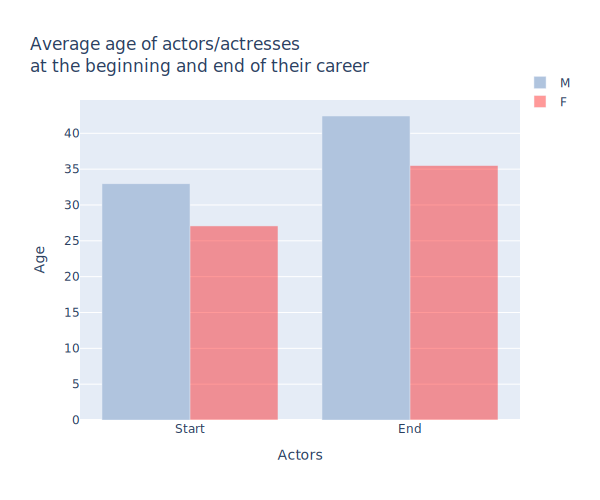

In [60]:

fig = go.Figure()

fig.update_layout(
    autosize=True,
    width=600,
    height=500,
)
fig.add_trace(go.Bar(
    x=['Start', 'End'],
    y=[career_age["Start"]["M"], career_age["End"]["M"]],
    name='M',
    marker_color='lightsteelblue'
))
fig.add_trace(go.Bar(
    x=['Start', 'End'],
    y=[career_age["Start"]["F"], career_age["End"]["F"]],
    name='F',
    marker_color='red',
    opacity=0.4
))
fig.update_layout(
    title="Average age of actors/actresses <br>at the beginning and end of their career",
    xaxis=dict(title="Actors"),
    yaxis=dict(title="Age"),
    legend=dict(x=1, y=1.1, orientation="v"),
)
fig.show("svg")

fig.write_html("average_age_of_actors.html")

In [51]:
#same analysis but looking at top movies
top_movies = df_movie.sort_values(by= "Movie_box_office_revenue", ascending=False).head(7217)["Wikipedia_movie_ID"]
#7217 films wiht revenue

In [52]:
#selecting all the actors that play in big movie
actors_top_movies = df_chara_small[df_chara_small.apply(lambda x: any(i in list(top_movies) for i in x["Wikipedia_movie_ID"]) if type(x["Wikipedia_movie_ID"])==list else False, axis=1)]

In [53]:
def find_movie_pos_and_age(movie_list):
    ##finds the position of the top movie in the movie list of the df
    dic_movie = {}
    for mov in movie_list:
        if mov in list(top_movies):
            dic_movie[mov] = movie_list.index(mov)
    
    return dic_movie

actors_top_movies["top_films"] = actors_top_movies["Wikipedia_movie_ID"].apply(lambda x: list(find_movie_pos_and_age(x).keys()))
actors_top_movies["index_of_top_film"] = actors_top_movies["Wikipedia_movie_ID"].apply(lambda x: list(find_movie_pos_and_age(x).values()))

/var/folders/4l/yz8mrkq91sl802y_wzywbvnc0000gn/T/ipykernel_73609/3971206100.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/4l/yz8mrkq91sl802y_wzywbvnc0000gn/T/ipykernel_73609/3971206100.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [54]:
actors_top_movies["Age_at_top_film"] = actors_top_movies.apply(lambda x: [x["Actor_age_at_movie_release"][i] for i in x["index_of_top_film"]], axis=1)

/var/folders/4l/yz8mrkq91sl802y_wzywbvnc0000gn/T/ipykernel_73609/2701808925.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [55]:
age_top = actors_top_movies[["Actor_gender", "Age_at_top_film"]].explode("Age_at_top_film")

34.35287735635821
40.48450587230901


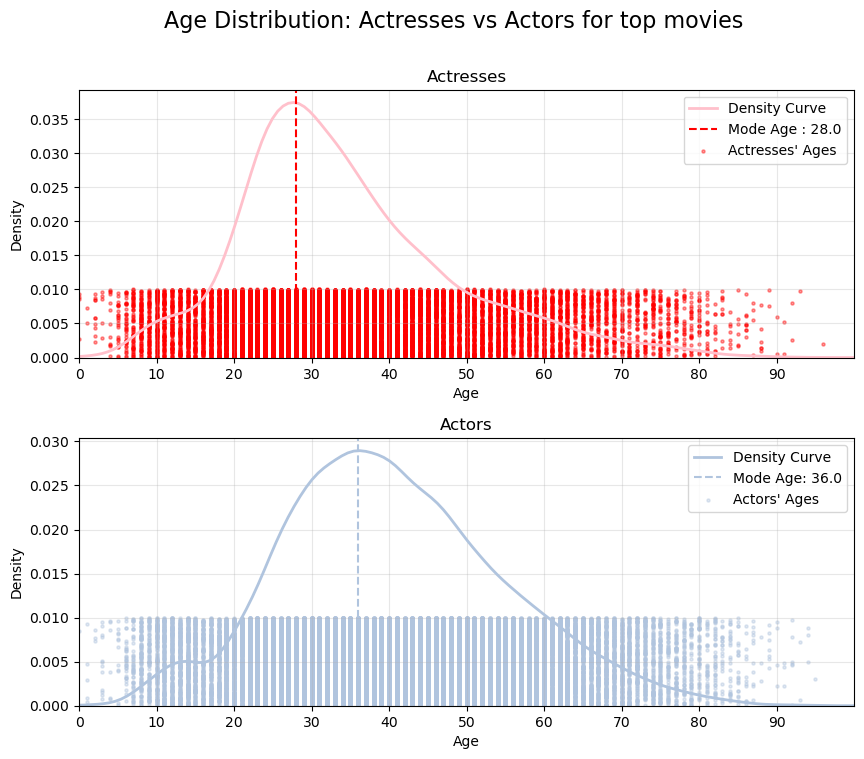

In [56]:
#gender analysis for top actors 
import seaborn as sns
import statistics as stats
ages_w = age_top[(age_top['Actor_gender'] == 'F') & (age_top['Age_at_top_film'].notna())]['Age_at_top_film']
ages_m = age_top[(age_top['Actor_gender'] == 'M') & (age_top['Age_at_top_film'].notna())]['Age_at_top_film']

print(ages_w.mean())
print(ages_m.mean())
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=False, gridspec_kw={'hspace': 0.3})


sns.kdeplot(ages_w, ax=axes[0], color='pink', linewidth=2, label="Density Curve")

axes[0].axvline(stats.mode(ages_w), color='red', linestyle='--', label=f"Mode Age : {stats.mode(ages_w)}")
axes[0].scatter(
    ages_w, 
    np.random.uniform(0, 0.01, len(ages_w)), 
    color='red', 
    alpha=0.4, 
    s=5, 
    label="Actresses' Ages"
)
axes[0].set_xlim(0, 100)
axes[0].set_title("Actresses")
axes[0].set_xlabel("Age")
axes[0].set_xticks(np.arange(0, 100, 10))

axes[0].legend()
axes[0].grid(alpha=0.3)


sns.kdeplot(ages_m, ax=axes[1], color='lightsteelblue', linewidth=2, label="Density Curve")
axes[1].axvline(stats.mode(ages_m), color='lightsteelblue', linestyle='--', label=f"Mode Age: {stats.mode(ages_m)}")
axes[1].scatter(
    ages_m, 
    np.random.uniform(0, 0.01, len(ages_m)), 
    color='lightsteelblue', 
    alpha=0.4, 
    s=5, 
    label="Actors' Ages"
)

axes[1].set_title("Actors")
axes[1].set_xlabel("Age")
axes[1].set_xlim(0, 100)
axes[1].set_xticks(np.arange(0, 100, 10))

axes[1].legend()
axes[1].grid(alpha=0.3)

plt.suptitle("Age Distribution: Actresses vs Actors for top movies", fontsize=16)
plt.show("svg")


#fig.savefig("age_distribution.png")


### Looking at age distribution for first role

In [57]:
df_age_1st = df_chara_small[["Movie_release_date_1st_role", "Actor_name", "Actor_date_of_birth", 'Actor_gender', 'Wikipedia_movie_ID']].dropna()
df_age_1st["Actor_date_of_birth"] = df_age_1st["Actor_date_of_birth"].apply(lambda x: x[:4] if type(x)!= int else x)
df_age_1st = df_age_1st.explode("Movie_release_date_1st_role")
df_age_1st["Age_first_role"] = df_age_1st.apply(lambda x: int(x["Movie_release_date_1st_role"]) - int(x["Actor_date_of_birth"]), axis=1)



In [58]:
len(df_age_1st)

22560

mean age women: 33.31373725254949
mean age men: 40.8437400140602


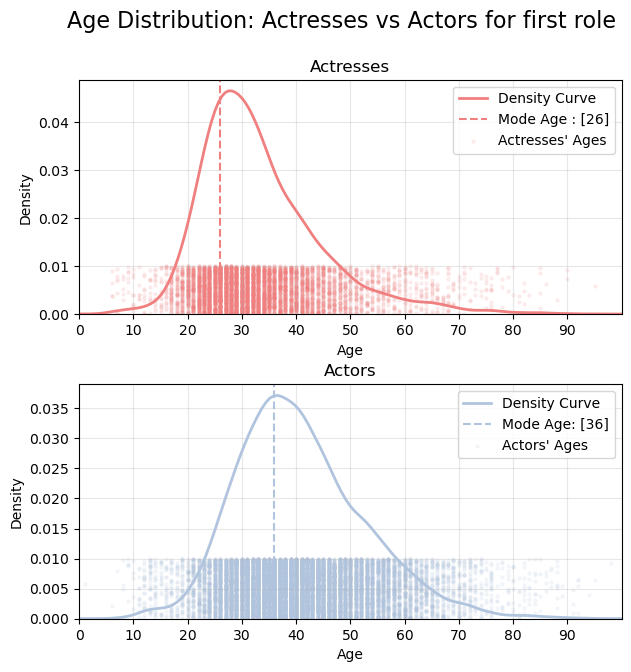

In [59]:
import seaborn as sns
import statistics as stats
ages_w = df_age_1st[(df_age_1st['Actor_gender'] == 'F') & (df_age_1st["Movie_release_date_1st_role"] > 1900)]['Age_first_role']
ages_m = df_age_1st[(df_age_1st['Actor_gender'] == 'M') & (df_age_1st["Movie_release_date_1st_role"] > 1900)]['Age_first_role']

print("mean age women:", ages_w.mean())
print("mean age men:", ages_m.mean())
multm = stats.multimode(ages_m)
multw = stats.multimode(ages_w)
fig, axes = plt.subplots(2, 1, figsize=(7, 7), sharex=False, gridspec_kw={'hspace': 0.3})


sns.kdeplot(ages_w, ax=axes[0], color='lightcoral', linewidth=2, label="Density Curve")

axes[0].axvline(multw, color='lightcoral', linestyle='--', label=f"Mode Age : {multw}")
axes[0].scatter(
    ages_w, 
    np.random.uniform(0, 0.01, len(ages_w)), 
    color='lightcoral', 
    alpha=0.1, 
    s=5, 
    label="Actresses' Ages"
)

axes[0].set_title("Actresses")
axes[0].set_xlabel("Age")
axes[0].set_xlim(0, 100)
axes[0].set_xticks(np.arange(0, 100, 10))
axes[0].legend()
axes[0].grid(alpha=0.3)


sns.kdeplot(ages_m, ax=axes[1], color='lightsteelblue', linewidth=2, label="Density Curve")
axes[1].axvline(multm, color='lightsteelblue', linestyle='--', label=f"Mode Age: {multm}")
axes[1].scatter(
    ages_m, 
    np.random.uniform(0, 0.01, len(ages_m)), 
    color='lightsteelblue', 
    alpha=0.1, 
    s=5, 
    label="Actors' Ages"
)

axes[1].set_title("Actors")
axes[1].set_xlabel("Age")
axes[1].set_xlim(0, 100)
axes[1].set_xticks(np.arange(0, 100, 10))
axes[1].legend()
axes[1].grid(alpha=0.3)


plt.suptitle("Age Distribution: Actresses vs Actors for first role", fontsize=16)
plt.show("svg")

#fig.savefig("age_distribution_first_role.png")